<a href="https://colab.research.google.com/github/chakshu-dhannawat/Renewale-Energy-Forecast/blob/main/TFT_Hourly.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch_lightning
!pip install pytorch_forecasting
!pip install torchmetrics==0.5.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 585 kB 29.8 MB/s 
     |████████████████████████████████| 140 kB 71.2 MB/s 
     |████████████████████████████████| 596 kB 65.1 MB/s 
     |████████████████████████████████| 419 kB 72.3 MB/s 
     |████████████████████████████████| 1.1 MB 60.6 MB/s 
     |████████████████████████████████| 271 kB 73.6 MB/s 
     |████████████████████████████████| 144 kB 71.9 MB/s 
     |████████████████████████████████| 94 kB 4.2 MB/s 
  Attempting uninstall: PyYAML
    Found existing installation: PyYAML 3.13
    Uninstalling PyYAML-3.13:
      Successfully uninstalled PyYAML-3.13
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 127 kB 27.4 MB/s 
     |████████████████████████████████| 308 kB 64.5 MB/s 
     |████████████████████████████████| 81 kB 10.7 MB/s 
     |████████████

In [ ]:
#import os
#import warnings

#warnings.filterwarnings("ignore")  # avoid printing out absolute paths

#os.chdir("/content/Pytorch_TFT/")

# **Importing librairies**

In [ ]:
import copy
from pathlib import Path
import warnings
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pytorch_lightning as pl
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor
from pytorch_lightning.loggers import TensorBoardLogger
import torch

from pytorch_forecasting import Baseline, TemporalFusionTransformer, TimeSeriesDataSet
from pytorch_forecasting.data import GroupNormalizer
from pytorch_forecasting.metrics import SMAPE, PoissonLoss, QuantileLoss
from pytorch_forecasting.models.temporal_fusion_transformer.tuning import optimize_hyperparameters

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [ ]:

data = pd.read_csv("/content/drive/MyDrive/Wind try/289693_52.37_-1.70_2019.csv",encoding = 'unicode_escape',header=2)
#data["year"] = data["Date Time"].dt.year
data.columns.to_list()

#EBitda, OperatingIncome ratio, NetIncome, Net Debt, Dividend Yield, cash per share, gross Profit
data

,Year,Month,Day,Hour,Minute,Temperature,Cloud Type,GHI,Relative Humidity,Pressure,Precipitable Water,Wind Direction,Wind Speed,Unnamed: 13
0,2019,1,1,0,30,6.4,1,0,94.72,1021,1.0,286,3.1,NaN
1,2019,1,1,1,30,6.5,4,0,94.54,1022,1.1,287,2.9,NaN
2,2019,1,1,2,30,6.6,1,0,93.93,1022,1.2,287,3.0,NaN
3,2019,1,1,3,30,6.9,6,0,92.77,1021,1.3,288,3.3,NaN
4,2019,1,1,4,30,7.1,6,0,93.06,1021,1.4,291,3.6,NaN
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,2019,12,31,19,30,6.4,1,0,98.74,1019,1.1,107,3.0,NaN
8756,2019,12,31,20,30,6.4,1,0,98.54,1019,1.0,111,2.9,NaN
8757,2019,12,31,21,30,6.2,3,0,99.32,1019,1.0,113,2.7,NaN
8758,2019,12,31,22,30,5.9,4,0,99.47,1018,0.9,117,2.7,NaN


# **Build Dataset and train/validation Dataloaders**

In [ ]:
data=data.dropna(axis=1)
data.head(20)

,Year,Month,Day,Hour,Minute,Temperature,Cloud Type,GHI,Relative Humidity,Pressure,Precipitable Water,Wind Direction,Wind Speed
0,2019,1,1,0,30,6.4,1,0,94.72,1021,1.0,286,3.1
1,2019,1,1,1,30,6.5,4,0,94.54,1022,1.1,287,2.9
2,2019,1,1,2,30,6.6,1,0,93.93,1022,1.2,287,3.0
3,2019,1,1,3,30,6.9,6,0,92.77,1021,1.3,288,3.3
4,2019,1,1,4,30,7.1,6,0,93.06,1021,1.4,291,3.6
5,2019,1,1,5,30,7.3,6,0,93.32,1021,1.5,294,3.7
6,2019,1,1,6,30,7.4,7,0,94.48,1021,1.5,296,3.7
7,2019,1,1,7,30,7.4,6,0,96.16,1021,1.5,297,3.5
8,2019,1,1,8,30,7.6,7,13,96.18,1022,1.4,298,3.5
9,2019,1,1,9,30,8.2,7,6,94.24,1022,1.4,302,3.6


In [ ]:
data=data.dropna()
data.head(20)

,Year,Month,Day,Hour,Minute,Temperature,Cloud Type,GHI,Relative Humidity,Pressure,Precipitable Water,Wind Direction,Wind Speed
0,2019,1,1,0,30,6.4,1,0,94.72,1021,1.0,286,3.1
1,2019,1,1,1,30,6.5,4,0,94.54,1022,1.1,287,2.9
2,2019,1,1,2,30,6.6,1,0,93.93,1022,1.2,287,3.0
3,2019,1,1,3,30,6.9,6,0,92.77,1021,1.3,288,3.3
4,2019,1,1,4,30,7.1,6,0,93.06,1021,1.4,291,3.6
5,2019,1,1,5,30,7.3,6,0,93.32,1021,1.5,294,3.7
6,2019,1,1,6,30,7.4,7,0,94.48,1021,1.5,296,3.7
7,2019,1,1,7,30,7.4,6,0,96.16,1021,1.5,297,3.5
8,2019,1,1,8,30,7.6,7,13,96.18,1022,1.4,298,3.5
9,2019,1,1,9,30,8.2,7,6,94.24,1022,1.4,302,3.6


In [ ]:
data.shape

(8760, 13)

In [ ]:
data.dtypes

Year                    int64
Month                   int64
Day                     int64
Hour                    int64
Minute                  int64
Temperature           float64
Cloud Type              int64
GHI                     int64
Relative Humidity     float64
Pressure                int64
Precipitable Water    float64
Wind Direction          int64
Wind Speed            float64
dtype: object

In [ ]:
data['dateInt']=data['Year'].astype(str) + data['Month'].astype(str).str.zfill(2)+ data['Day'].astype(str).str.zfill(2)
data['Date'] = pd.to_datetime(data['dateInt'], format='%Y%m%d')

In [ ]:
data=data.drop(['Year','dateInt'], axis=1)
data

,Month,Day,Hour,Minute,Temperature,Cloud Type,GHI,Relative Humidity,Pressure,Precipitable Water,Wind Direction,Wind Speed,Date
0,1,1,0,30,6.4,1,0,94.72,1021,1.0,286,3.1,2019-01-01
1,1,1,1,30,6.5,4,0,94.54,1022,1.1,287,2.9,2019-01-01
2,1,1,2,30,6.6,1,0,93.93,1022,1.2,287,3.0,2019-01-01
3,1,1,3,30,6.9,6,0,92.77,1021,1.3,288,3.3,2019-01-01
4,1,1,4,30,7.1,6,0,93.06,1021,1.4,291,3.6,2019-01-01
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,12,31,19,30,6.4,1,0,98.74,1019,1.1,107,3.0,2019-12-31
8756,12,31,20,30,6.4,1,0,98.54,1019,1.0,111,2.9,2019-12-31
8757,12,31,21,30,6.2,3,0,99.32,1019,1.0,113,2.7,2019-12-31
8758,12,31,22,30,5.9,4,0,99.47,1018,0.9,117,2.7,2019-12-31


In [ ]:
data["time_idx"] = data.index
data

,Month,Day,Hour,Minute,Temperature,Cloud Type,GHI,Relative Humidity,Pressure,Precipitable Water,Wind Direction,Wind Speed,Date,time_idx
0,1,1,0,30,6.4,1,0,94.72,1021,1.0,286,3.1,2019-01-01,0
1,1,1,1,30,6.5,4,0,94.54,1022,1.1,287,2.9,2019-01-01,1
2,1,1,2,30,6.6,1,0,93.93,1022,1.2,287,3.0,2019-01-01,2
3,1,1,3,30,6.9,6,0,92.77,1021,1.3,288,3.3,2019-01-01,3
4,1,1,4,30,7.1,6,0,93.06,1021,1.4,291,3.6,2019-01-01,4
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8755,12,31,19,30,6.4,1,0,98.74,1019,1.1,107,3.0,2019-12-31,8755
8756,12,31,20,30,6.4,1,0,98.54,1019,1.0,111,2.9,2019-12-31,8756
8757,12,31,21,30,6.2,3,0,99.32,1019,1.0,113,2.7,2019-12-31,8757
8758,12,31,22,30,5.9,4,0,99.47,1018,0.9,117,2.7,2019-12-31,8758


In [ ]:
data.dtypes

Month                          int64
Day                            int64
Hour                           int64
Minute                         int64
Temperature                  float64
Cloud Type                     int64
GHI                            int64
Relative Humidity            float64
Pressure                       int64
Precipitable Water           float64
Wind Direction                 int64
Wind Speed                   float64
Date                  datetime64[ns]
time_idx                       int64
dtype: object

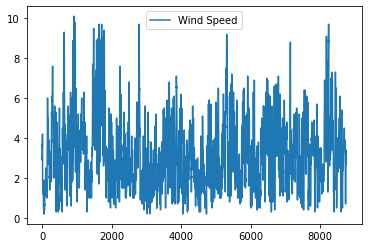

In [ ]:
plot_cols = ['Wind Speed']
plot_features = data[plot_cols]

_ = plot_features.plot(subplots=True)
plot_features = data[plot_cols][:]

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 8760 entries, 0 to 8759
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype         
---  ------              --------------  -----         
 0   Month               8760 non-null   int64         
 1   Day                 8760 non-null   int64         
 2   Hour                8760 non-null   int64         
 3   Minute              8760 non-null   int64         
 4   Temperature         8760 non-null   float64       
 5   Cloud Type          8760 non-null   int64         
 6   GHI                 8760 non-null   int64         
 7   Relative Humidity   8760 non-null   float64       
 8   Pressure            8760 non-null   int64         
 9   Precipitable Water  8760 non-null   float64       
 10  Wind Direction      8760 non-null   int64         
 11  Wind Speed          8760 non-null   float64       
 12  Date                8760 non-null   datetime64[ns]
 13  time_idx            8760 non-null   int64       

In [ ]:
data.tail(20)

,Month,Day,Hour,Minute,Temperature,Cloud Type,GHI,Relative Humidity,Pressure,Precipitable Water,Wind Direction,Wind Speed,Date,time_idx
8740,12,31,4,30,6.1,7,0,100.00,1018,1.6,71,2.3,2019-12-31,8740
8741,12,31,5,30,6.0,7,0,100.00,1019,1.6,79,2.5,2019-12-31,8741
8742,12,31,6,30,5.9,7,0,99.59,1019,1.5,85,2.6,2019-12-31,8742
8743,12,31,7,30,5.9,7,0,98.91,1019,1.5,88,2.8,2019-12-31,8743
8744,12,31,8,30,6.0,7,11,98.23,1020,1.5,90,3.1,2019-12-31,8744
8745,12,31,9,30,6.3,4,12,97.03,1020,1.4,91,3.3,2019-12-31,8745
8746,12,31,10,30,6.7,0,159,96.19,1020,1.4,93,3.4,2019-12-31,8746
8747,12,31,11,30,7.1,4,30,95.52,1020,1.3,96,3.4,2019-12-31,8747
8748,12,31,12,30,7.3,0,213,95.55,1020,1.3,98,3.4,2019-12-31,8748
8749,12,31,13,30,7.4,8,21,95.71,1019,1.2,98,3.1,2019-12-31,8749


In [ ]:
data['Time_series_id']='1'

In [ ]:
# load data: this is pandas dataframe with at least a column for
# * the target (what you want to predict)
# * the timeseries ID (which should be a unique string to identify each timeseries)
# * the time of the observation (which should be a monotonically increasing integer)
# data = ...

# define the dataset, i.e. add metadata to pandas dataframe for the model to understand it
max_encoder_length = 36
max_prediction_length = 6
#training_cutoff = "2014-11-31"  # day for cutoff
training_cutoff = data["time_idx"].max() - max_prediction_length
training = TimeSeriesDataSet(
    data[lambda x: x.time_idx <= training_cutoff],
    time_idx= "time_idx",  # column name of time of observation
    target= "Wind Speed",  # column name of target to predict
    group_ids=["Time_series_id"],  # column name(s) for timeseries IDs
    #max_encoder_length=max_encoder_length,  # how much history to use
    #max_prediction_length=max_prediction_length,  # how far to predict into future
    min_encoder_length=max_encoder_length // 3,  # keep encoder length long (as it is in the validation set)
    max_encoder_length=max_encoder_length,
    # covariates static for a timeseries ID
    #static_categoricals=[Pressure],
    #static_reals,
    # covariates known and unknown in the future to inform prediction
    #time_varying_known_categoricals=["Minute"],
    time_varying_known_reals=["time_idx", "Month","Day","Hour"],
    #time_varying_unknown_categoricals=[ ... ],
    time_varying_unknown_reals=["Wind Speed","Wind Direction","Precipitable Water","Relative Humidity","GHI"]
    #categorical_encoders={
        #'Month': *pytorch_forecasting.data.encoders.NaNLabelEncoder(add_nan=True)}
)

# create validation dataset using the same normalization techniques as for the training dataset
validation = TimeSeriesDataSet.from_dataset(training, data, min_prediction_idx=training.index.time.max() + 1, stop_randomization=True)

# convert datasets to dataloaders for training
batch_size = 128
train_dataloader = training.to_dataloader(train=True, batch_size=batch_size, num_workers=2)
val_dataloader = validation.to_dataloader(train=False, batch_size=batch_size, num_workers=2)

# **Build the model**

In [ ]:
# create PyTorch Lighning Trainer with early stopping
early_stop_callback = EarlyStopping(monitor="val_loss", min_delta=1e-5, patience=10, verbose=False, mode="min")
lr_logger = LearningRateMonitor()

trainer = pl.Trainer(
    max_epochs=50,
    weights_summary="top",
    # gpus=1,  # run on CPU, if on multiple GPUs, use accelerator="ddp"
    gradient_clip_val=0.1,
    limit_train_batches=30,  # 30 batches per epoch
    callbacks=[lr_logger, early_stop_callback],
    logger=TensorBoardLogger("lightning_logs")
)

# define network to train - the architecture is mostly inferred from the dataset, so that only a few hyperparameters have to be set by the user
tft = TemporalFusionTransformer.from_dataset(
    # dataset
    training,
    # architecture hyperparameters
    hidden_size=32,
    attention_head_size=1,
    dropout=0.1,
    hidden_continuous_size=16,
    # loss metric to optimize
    loss=QuantileLoss(),
    # logging frequency
    log_interval=2,
    # optimizer parameters
    learning_rate=0.04,
    reduce_on_plateau_patience=10
)
print(f"Number of parameters in network: {tft.size()/1e3:.1f}k")

GPU available: True, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


Number of parameters in network: 82.4k


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1817: PossibleUserWarning: GPU available but not used. Set `accelerator` and `devices` using `Trainer(accelerator='gpu', devices=1)`.
  category=PossibleUserWarning,
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."


/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1937: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Finding best initial lr:   0%|          | 0/100 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/models/base_model.py:792: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/models/base_model.py:792: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  fig, ax = plt.subplots()
/usr/local/lib/python3.7/dist-packages/pytorch_forecasting/models/base_model.py:792: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until expli

suggested learning rate: 0.061003900355223004


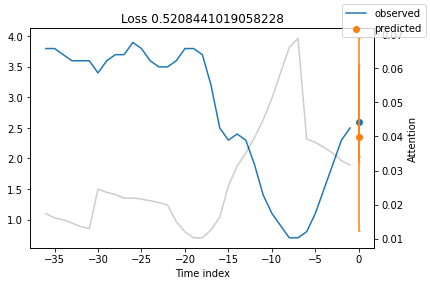

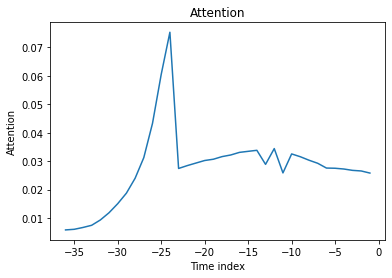

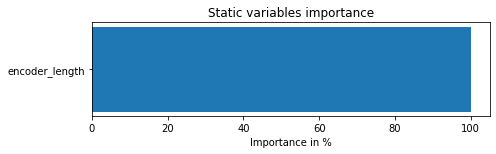

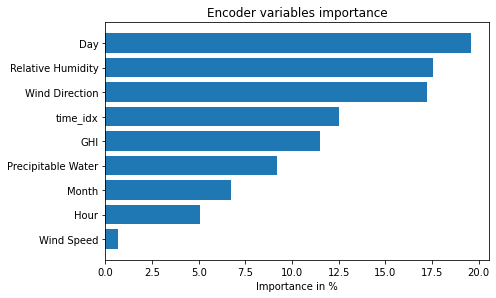

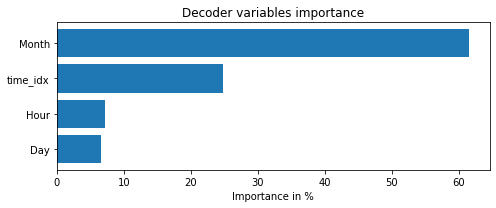

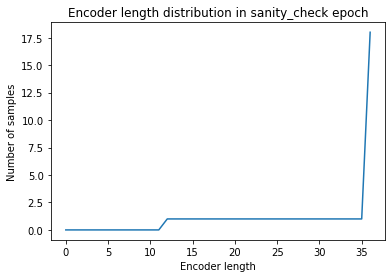

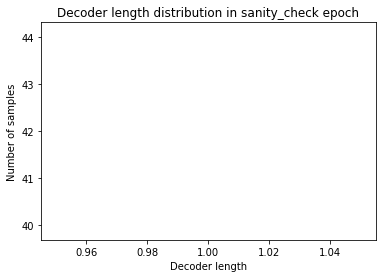

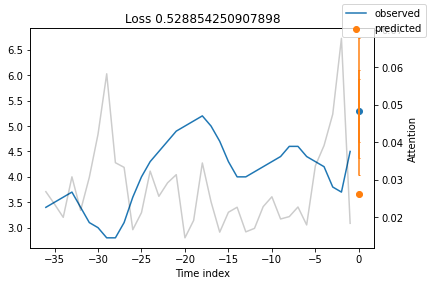

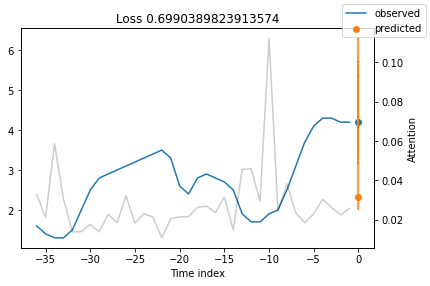

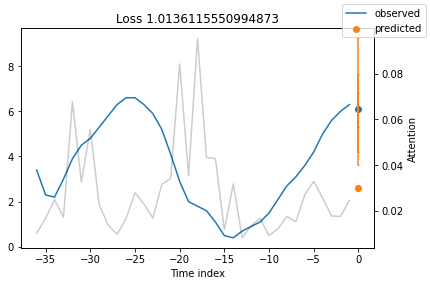

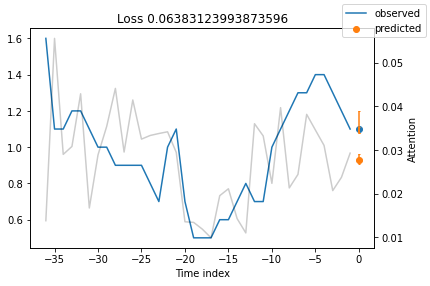

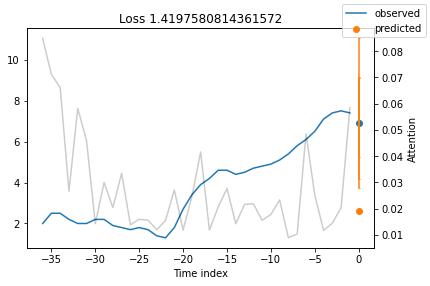

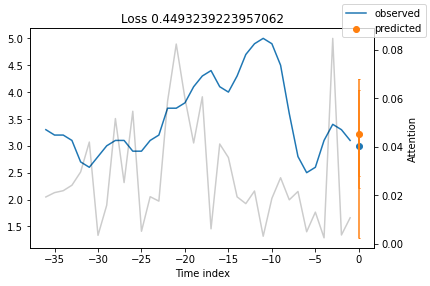

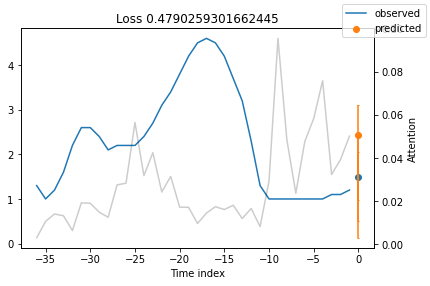

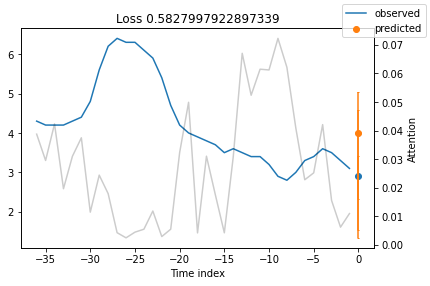

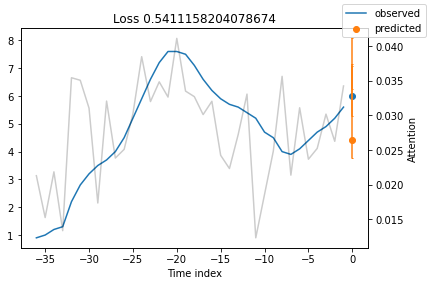

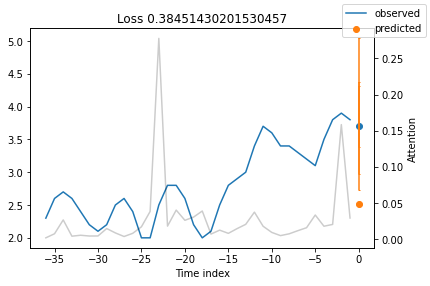

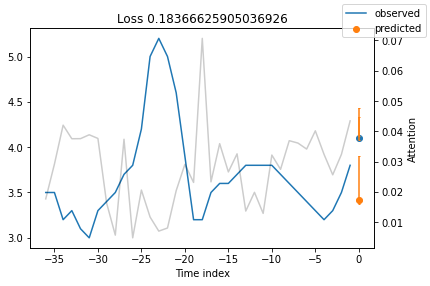

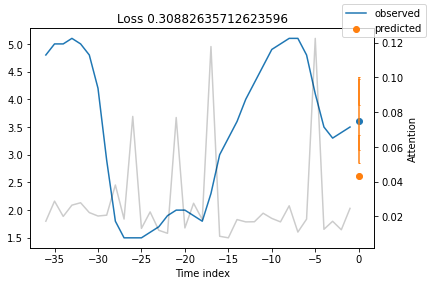

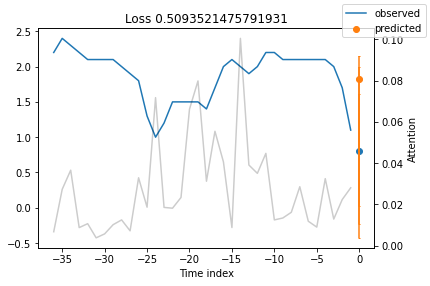

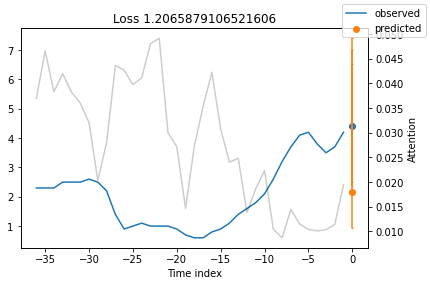

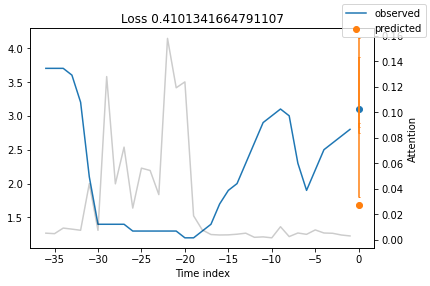

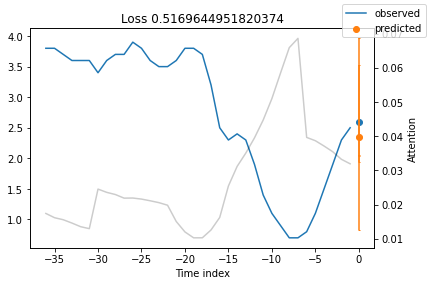

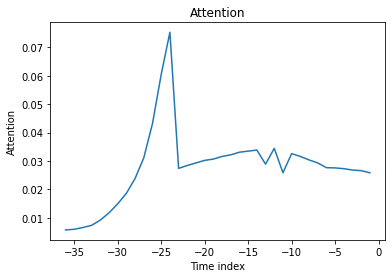

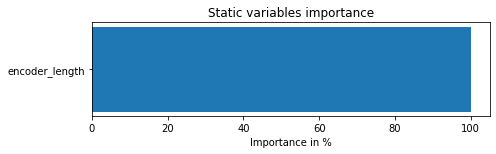

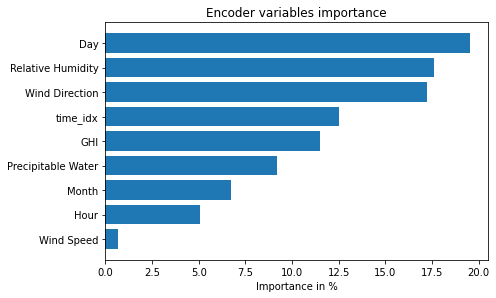

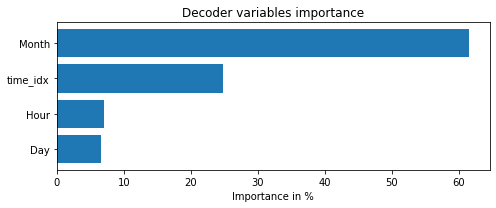

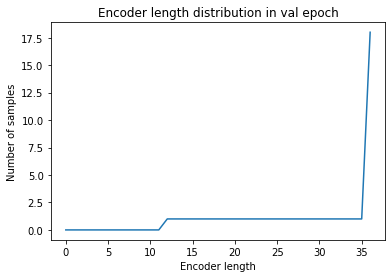

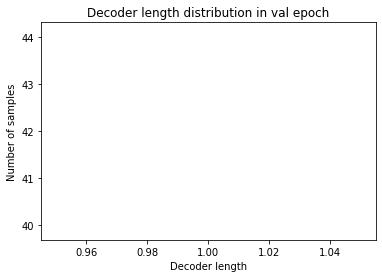

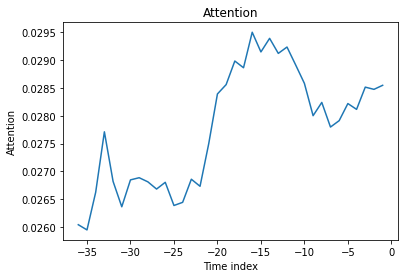

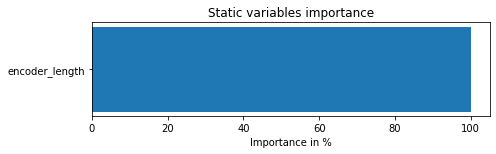

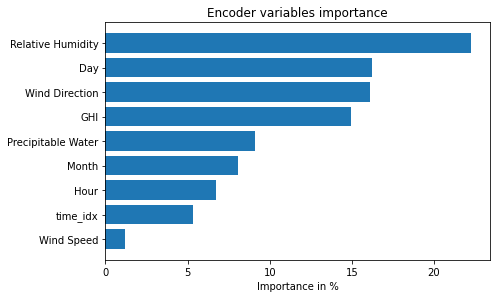

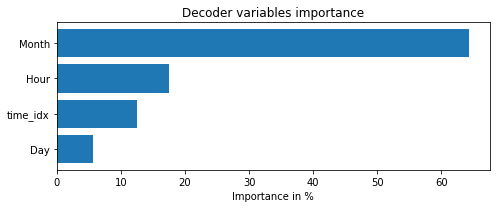

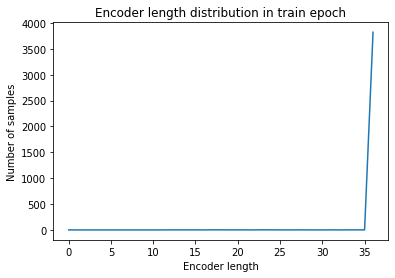

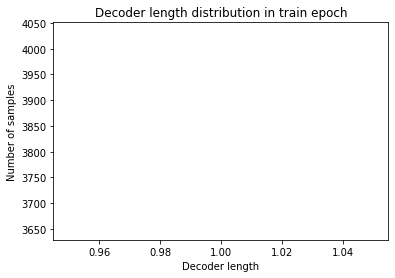

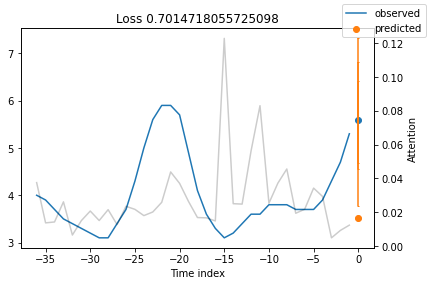

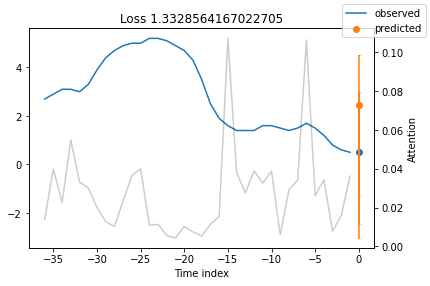

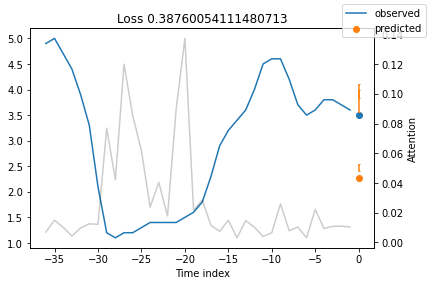

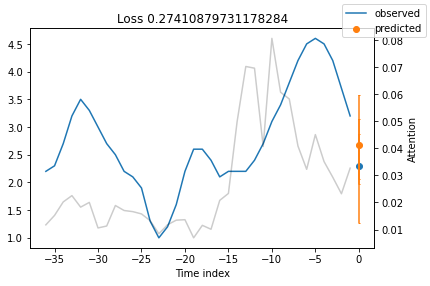

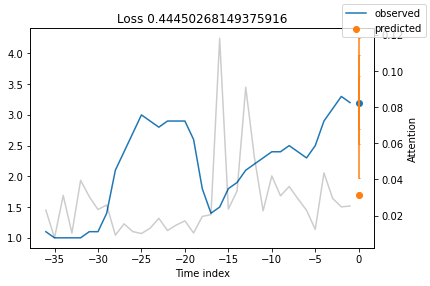

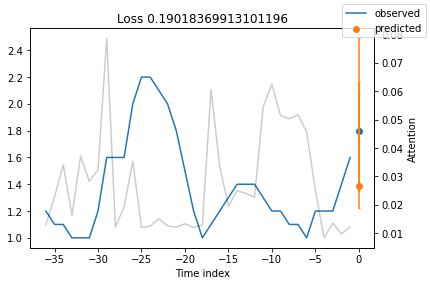

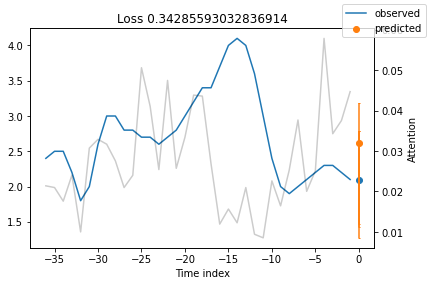

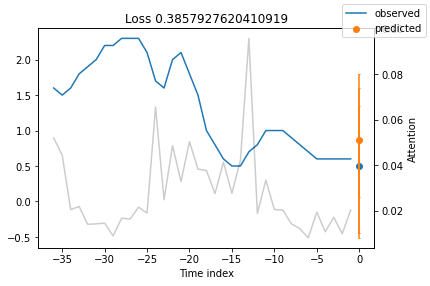

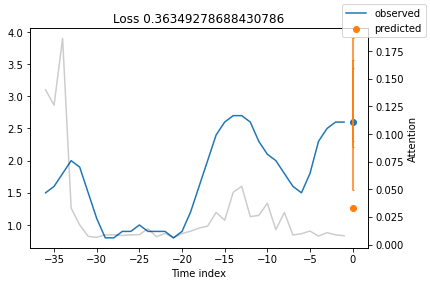

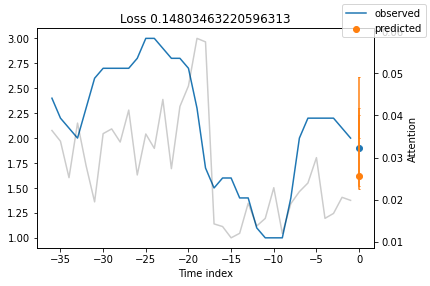

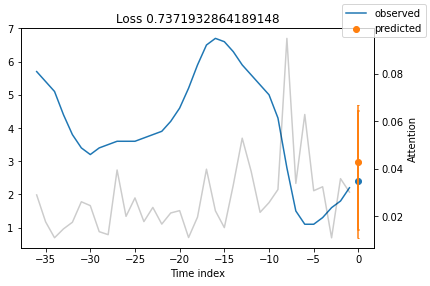

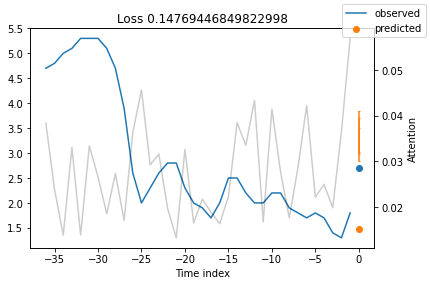

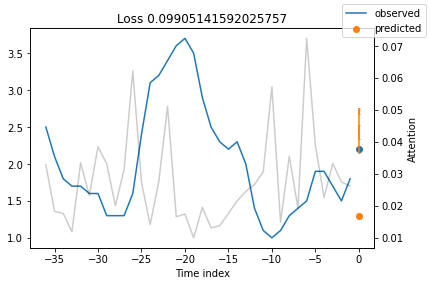

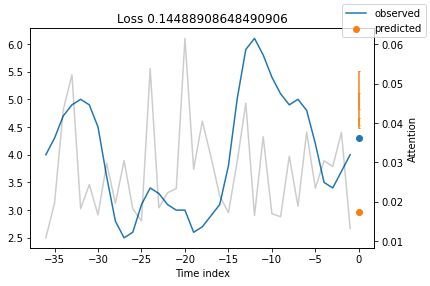

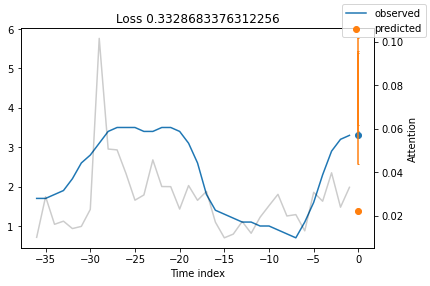

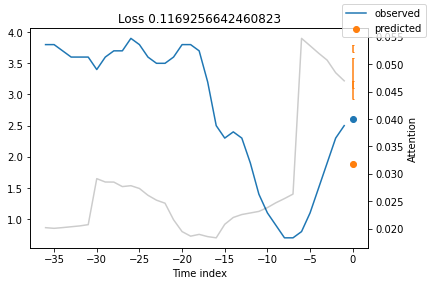

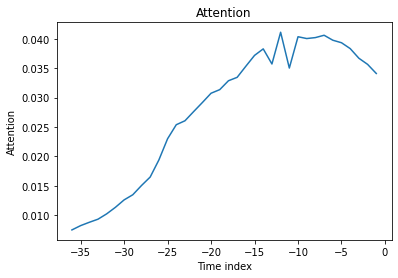

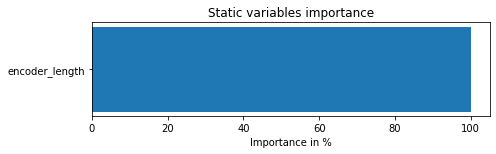

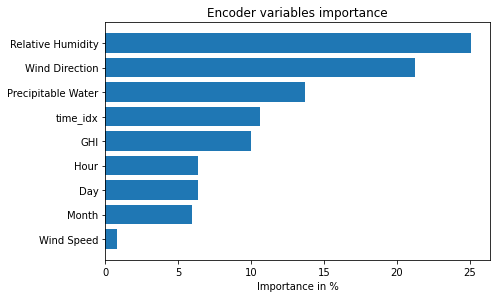

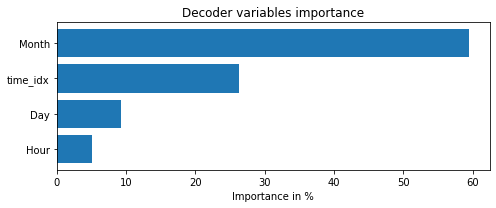

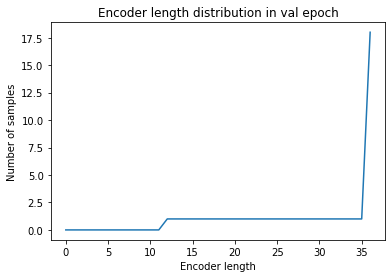

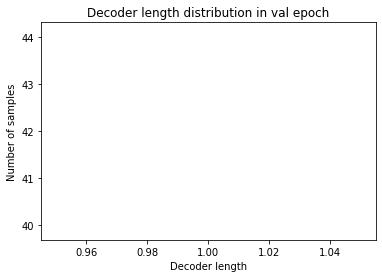

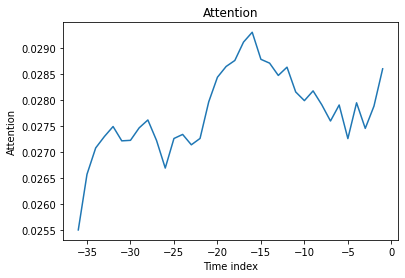

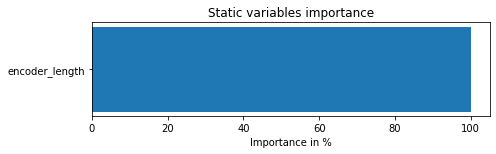

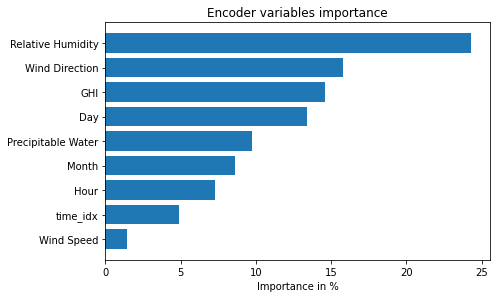

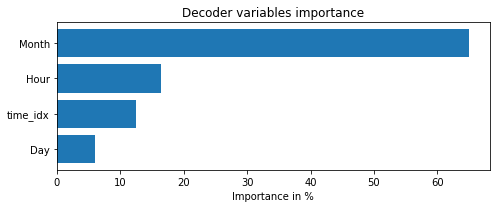

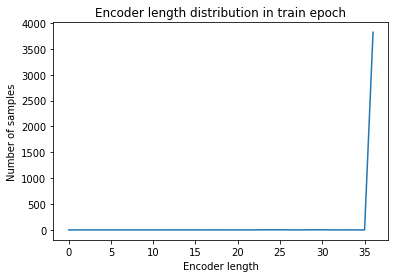

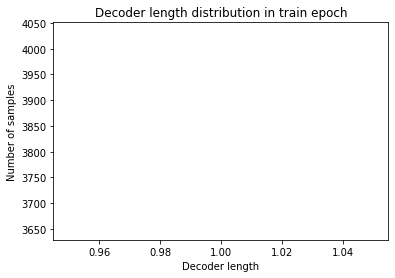

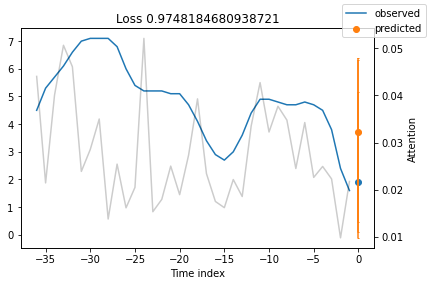

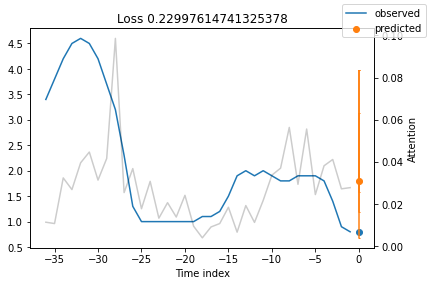

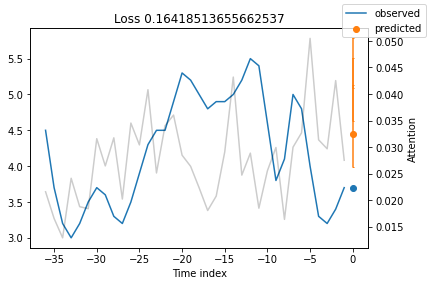

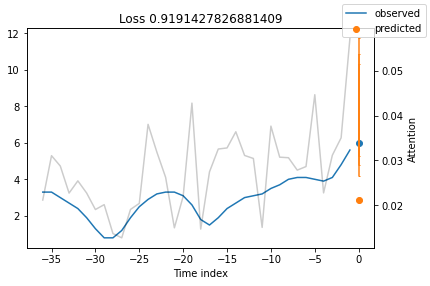

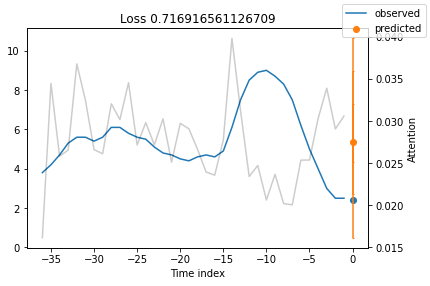

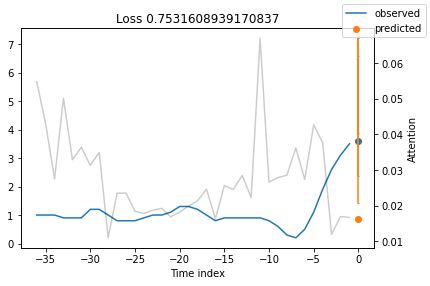

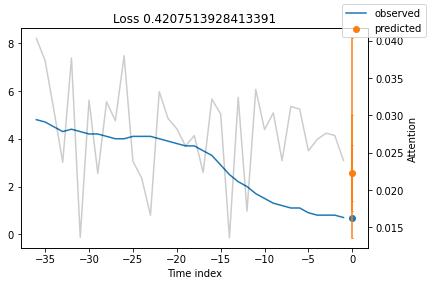

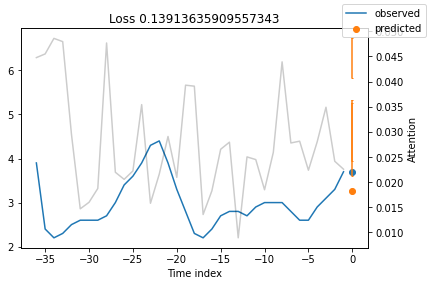

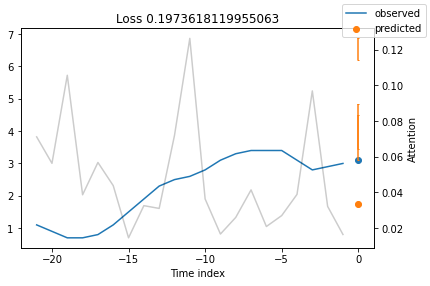

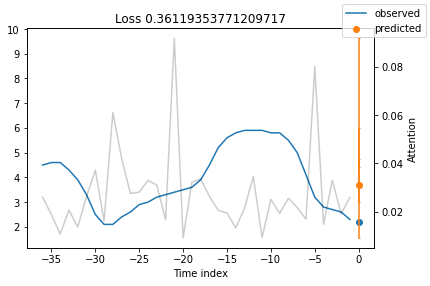

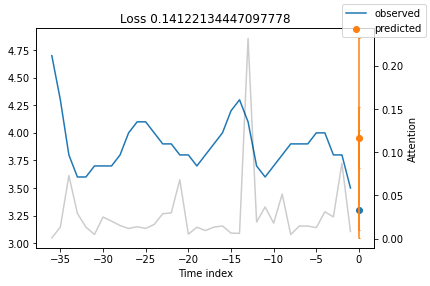

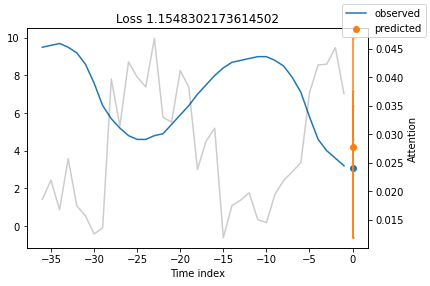

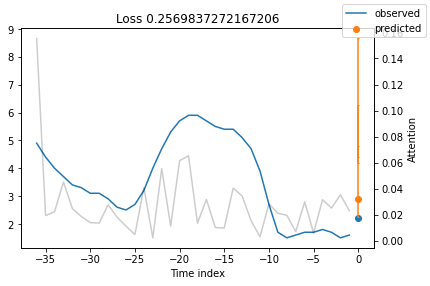

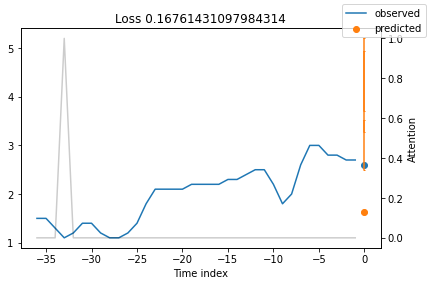

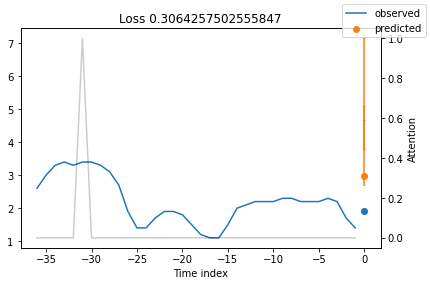

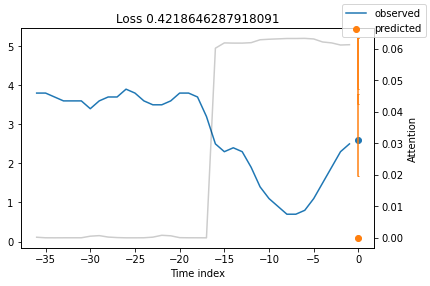

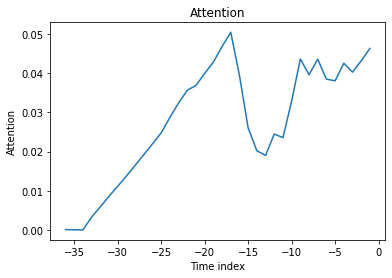

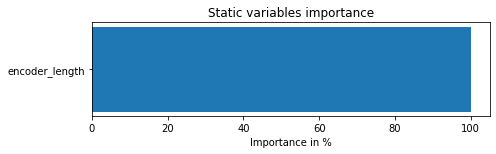

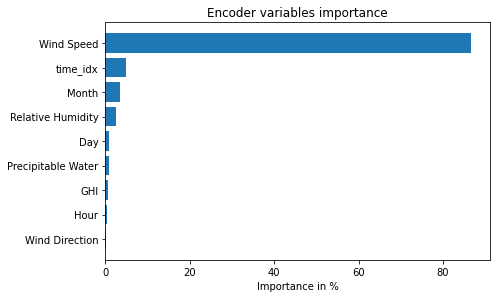

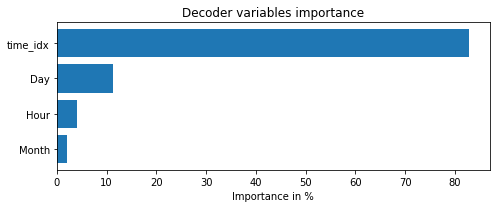

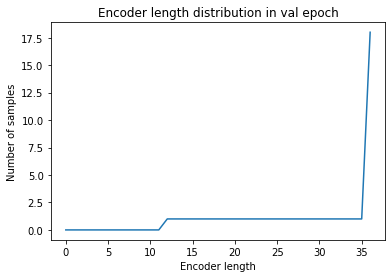

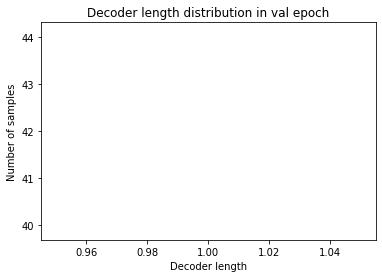

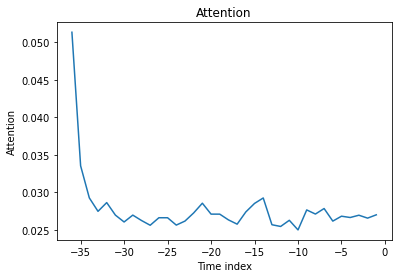

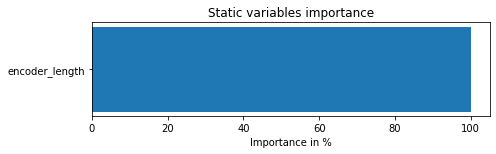

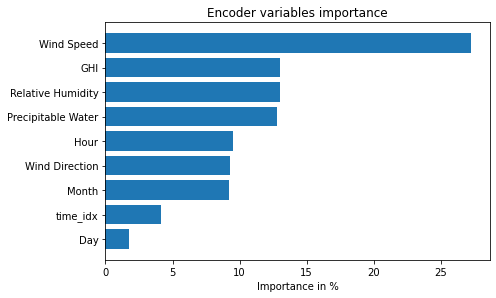

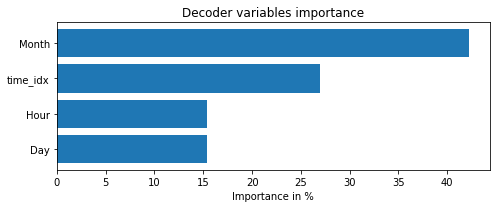

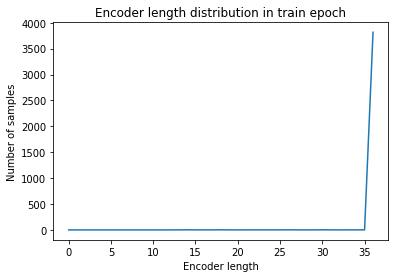

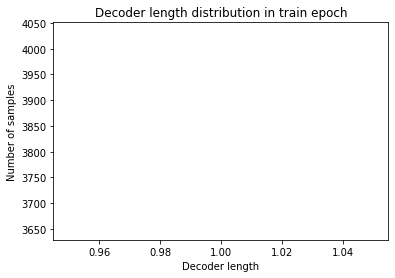

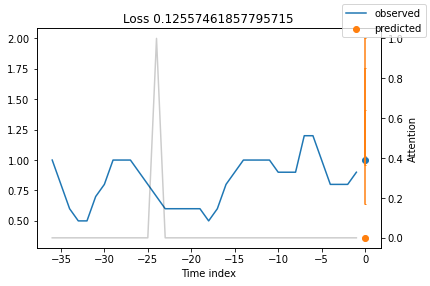

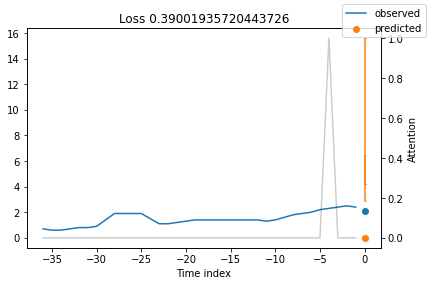

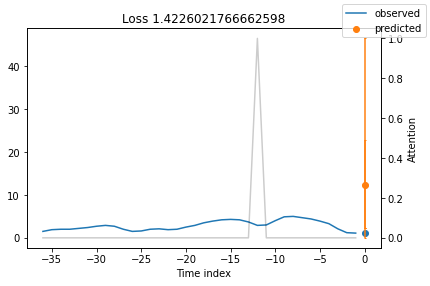

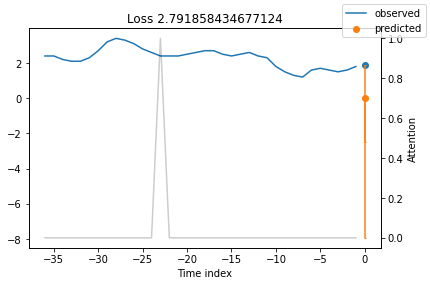

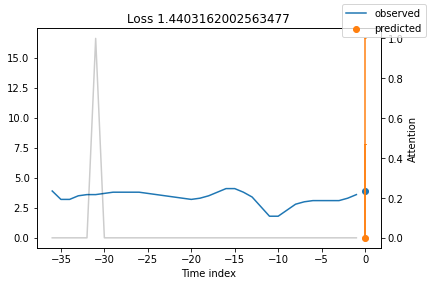

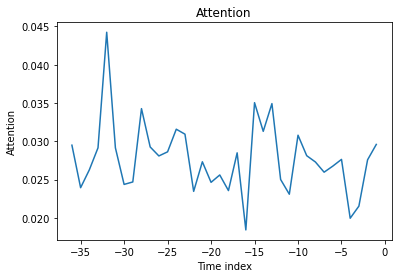

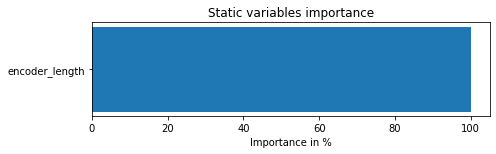

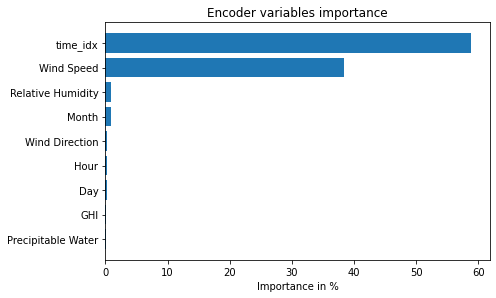

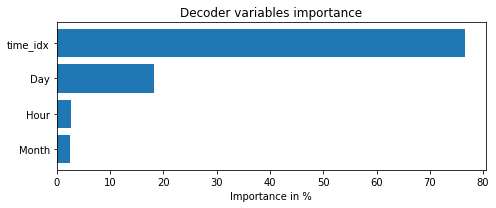

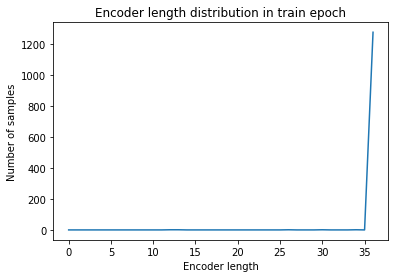

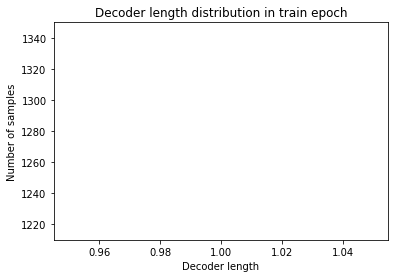

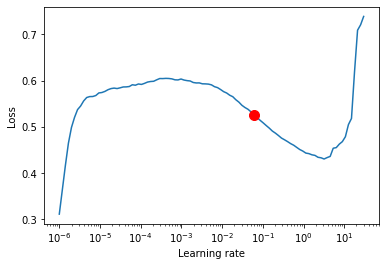

In [ ]:
# # find optimal learning rate
res = trainer.tuner.lr_find(
     tft,
     train_dataloaders=train_dataloader,
     val_dataloaders=val_dataloader,
     max_lr=30.0,
     min_lr=1e-6,
 )

print(f"suggested learning rate: {res.suggestion()}")
fig = res.plot(show=True, suggest=True)
fig.show()

# **Training**

In [ ]:
# fit the model on the data - redefine the model with the correct learning rate if necessary
trainer.fit(
    tft, train_dataloaders=train_dataloader, val_dataloaders=val_dataloader,
)


   | Name                               | Type                            | Params
----------------------------------------------------------------------------------------
0  | loss                               | QuantileLoss                    | 0     
1  | logging_metrics                    | ModuleList                      | 0     
2  | input_embeddings                   | MultiEmbedding                  | 0     
3  | prescalers                         | ModuleDict                      | 320   
4  | static_variable_selection          | VariableSelectionNetwork        | 1.8 K 
5  | encoder_variable_selection         | VariableSelectionNetwork        | 18.3 K
6  | decoder_variable_selection         | VariableSelectionNetwork        | 7.8 K 
7  | static_context_variable_selection  | GatedResidualNetwork            | 4.3 K 
8  | static_context_initial_hidden_lstm | GatedResidualNetwork            | 4.3 K 
9  | static_context_initial_cell_lstm   | GatedResidualNetwork            | 4.3 

Sanity Checking: 0it [00:00, ?it/s]

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/trainer/trainer.py:1937: PossibleUserWarning: The number of training batches (30) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for the training epoch.
  category=PossibleUserWarning,


Training: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

Validation: 0it [00:00, ?it/s]

# **Load the best model**

In [ ]:
# load the best model according to the validation loss
# (given that we use early stopping, this is not necessarily the last epoch)
best_model_path = trainer.checkpoint_callback.best_model_path
best_tft = TemporalFusionTransformer.load_from_checkpoint(best_model_path)

/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'loss' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['loss'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."
/usr/local/lib/python3.7/dist-packages/pytorch_lightning/utilities/parsing.py:262: UserWarning: Attribute 'logging_metrics' is an instance of `nn.Module` and is already saved during checkpointing. It is recommended to ignore them using `self.save_hyperparameters(ignore=['logging_metrics'])`.
  f"Attribute {k!r} is an instance of `nn.Module` and is already saved during checkpointing."


# **Predict**

In [ ]:
# calcualte mean absolute error on validation set
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_tft.predict(val_dataloader)

# **Evaluation**

In [ ]:
from sklearn.metrics import r2_score
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error


MAE = mean_absolute_error(actuals, predictions)
print("MAE = ", MAE)
MSE = mean_squared_error(actuals, predictions)
print("MSE = ", MSE)
R2_Score = r2_score(actuals, predictions, multioutput='variance_weighted')
print("R2_Score = {}%".format(round(R2_Score*100,2)))

MAE =  0.07279362
MSE =  0.008260049
R2_Score = 83.21%


# **Plotting results**

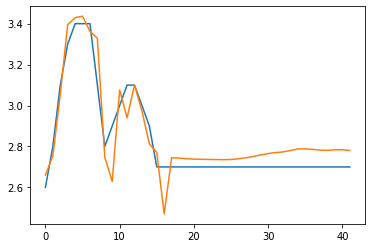

In [ ]:
plt.plot(actuals)
plt.plot(predictions)
plt.show()

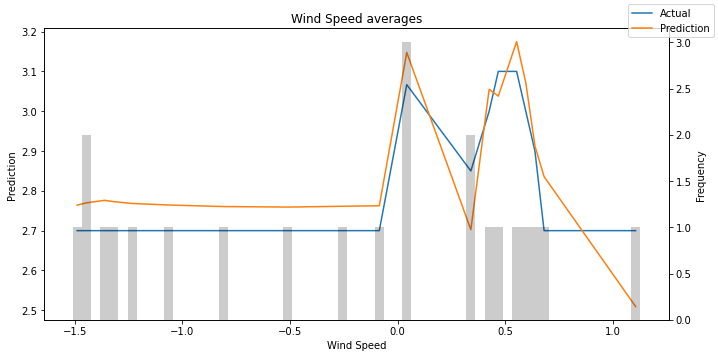

In [ ]:
predictions, x = best_tft.predict(val_dataloader, return_x=True)
predictions_vs_actuals = best_tft.calculate_prediction_actual_by_variable(x, predictions)
best_tft.plot_prediction_actual_by_variable(predictions_vs_actuals,'Wind Speed');